In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
TRAIN_DATA_DIR = '/Users/jantonchuk/Documents/NU/MSDS-462/fmri-data/training/'
VALIDATION_DATA_DIR = '/Users/jantonchuk/Documents/NU/MSDS-462/fmri-data/testing/'
TRAIN_SAMPLES = 98
VALIDATION_SAMPLES = 98
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 14

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [4]:
train_generator = train_datagen.flow_from_directory(
                        TRAIN_DATA_DIR,
                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        seed=12345,
                        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
                        VALIDATION_DATA_DIR,
                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        class_mode='categorical')

Found 98 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [5]:
def model_maker():
    base_model = MobileNet(include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))
    for layer in base_model.layers[:]:
        layer.trainable = False # Freeze the layers
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [6]:
model = model_maker()
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(lr=0.001),
              metrics=['acc'])
num_steps = math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE)
print(num_steps)
model.fit(train_generator,
          steps_per_epoch=num_steps,
          epochs=25,
          validation_data=validation_generator,
          validation_steps=num_steps)

7
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7 steps, validate for 7 steps
Epoch 1/25
7/7 [==============================] - 7s 1s/step - loss: 1.2157 - acc: 0.4490 - val_loss: 0.9269 - val_acc: 0.5000
Epoch 2/25
7/7 [==============================] - 5s 707ms/step - loss: 0.7755 - acc: 0.5714 - val_loss: 0.7057 - val_acc: 0.5612
Epoch 3/25
7/7 [==============================] - 6s 862ms/step - loss: 0.5291 - acc: 0.6735 - val_loss: 0.6797 - val_acc: 0.5714
Epoch 4/25
7/7 [==============================] - 6s 875ms/step - loss: 0.5035 - acc: 0.7449 - val_loss: 0.8630 - val_acc: 0.5306
Epoch 5/25
7/7 [==============================] - 7s 1s/step - loss: 0.4401 - acc: 0.8163 - val_loss: 0.6345 - val_acc: 0.5918
Epoch 6/25
7/7 [==============================] - 6s 873ms/step - loss: 0.3449 - acc: 0.8469 - val_loss: 0.7943 - val_acc: 0.5510
Epoch 7/25
7/7 [==============================] - 7s 938ms/step - loss: 0.3468 - acc: 0.8265 - val_loss: 0.8039 - val_acc: 0.5510
Epoc

In [7]:
model.save('model.h5')

In [8]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

In [9]:
img_path = '/Users/jantonchuk/Documents/NU/MSDS-462/fmri-data/yes/Y250.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array) # Preprocess the image
prediction = model.predict(preprocessed_img)
print(prediction)
print(validation_generator.class_indices)

[[0.9910948 0.0089051]]
{'no': 0, 'yes': 1}


#### Validation

In [10]:
# VARIABLES
IMG_WIDTH, IMG_HEIGHT = 224, 224
VALIDATION_DATA_DIR = '/Users/jantonchuk/Documents/NU/MSDS-462/fmri-data/validation/'
VALIDATION_BATCH_SIZE = 64

# DATA GENERATORS
validation_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DATA_DIR,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=VALIDATION_BATCH_SIZE,
        shuffle=False,
        class_mode='categorical')
ground_truth = validation_generator.classes

Found 20 images belonging to 2 classes.


In [11]:
predictions = model.predict(validation_generator)

In [12]:
# Let's view the names of the files.
filenames = validation_generator.filenames
print(len(filenames))
print(filenames[:10])

20
['no/25 no.jpg', 'no/26 no.jpg', 'no/27 no.jpg', 'no/28 no.jpg', 'no/29 no.jpg', 'no/30 no.jpg', 'no/31 no.jpg', 'no/32 no.jpg', 'no/33 no.jpg', 'no/34 no.jpg']


In [13]:
ground_truth = validation_generator.classes
print(ground_truth[:10])
print(len(ground_truth))

[0 0 0 0 0 0 0 0 0 0]
20


In [14]:
label_to_index = validation_generator.class_indices
print(label_to_index)

{'no': 0, 'yes': 1}


In [15]:
index_to_label = dict((v, k) for k, v in label_to_index.items())
print(index_to_label)

{0: 'no', 1: 'yes'}


In [16]:
print(predictions[:10])

[[9.9759454e-01 2.4054479e-03]
 [9.9932671e-01 6.7331141e-04]
 [9.9705410e-01 2.9458993e-03]
 [8.1740201e-01 1.8259797e-01]
 [9.8511904e-01 1.4880883e-02]
 [9.9567223e-01 4.3277773e-03]
 [9.9107111e-01 8.9289034e-03]
 [9.0196651e-01 9.8033525e-02]
 [6.2941438e-01 3.7058565e-01]
 [9.9158597e-01 8.4140431e-03]]


In [17]:
prediction_index = []
for prediction in predictions:
    prediction_index.append(np.argmax(prediction))

In [18]:
prediction_index

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [19]:
def accuracy(predictions, ground_truth):
    total = 0
    for i, j in zip(predictions, ground_truth):
        if i == j:
            total += 1
    return total * 1.0 / len(predictions)

In [20]:
print(accuracy(prediction_index, ground_truth))

0.55


In [21]:
# prediction_table is a dict with index, prediction, ground truth
prediction_table = {}

for index, val in enumerate(predictions):
    # get argmax index
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [value_of_highest_probability,
                               index_of_highest_probability, ground_truth[index]]

assert len(predictions) == len(ground_truth) == len(prediction_table)

In [22]:
prediction_table

{0: [0.99759454, 0, 0],
 1: [0.9993267, 0, 0],
 2: [0.9970541, 0, 0],
 3: [0.817402, 0, 0],
 4: [0.98511904, 0, 0],
 5: [0.9956722, 0, 0],
 6: [0.9910711, 0, 0],
 7: [0.9019665, 0, 0],
 8: [0.6294144, 0, 0],
 9: [0.99158597, 0, 0],
 10: [0.9877315, 0, 1],
 11: [0.9642998, 0, 1],
 12: [0.95570916, 0, 1],
 13: [0.9616493, 0, 1],
 14: [0.56241894, 0, 1],
 15: [0.5782294, 0, 1],
 16: [0.7288066, 0, 1],
 17: [0.64945865, 0, 1],
 18: [0.8098252, 0, 1],
 19: [0.60328424, 1, 1]}

In [23]:
def get_images_with_sorted_probabilities(prediction_table,
                                         get_highest_probability,
                                         label,
                                         number_of_items,
                                         only_false_predictions=False):
    sorted_prediction_table = [(k, prediction_table[k])
                               for k in sorted(prediction_table,
                                               key=prediction_table.get,
                                               reverse=get_highest_probability)
                               ]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append(
                        [image_index, [probability, predicted_index, gt]])
            else:
                result.append(
                    [image_index, [probability, predicted_index, gt]])
    return result[:number_of_items]

In [24]:
def plot_images(filenames, distances, message):
    images = []
    
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        ax.set_title("\n\n" + filenames[i].split("/")[-1] + "\n" +
                     "\nProbability: " +
                     str(float("{0:.2f}".format(distances[i]))))
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)
        
def display(sorted_indices, message):
    similar_image_paths = []
    distances = []
    
    for name, value in sorted_indices:
        [probability, predicted_index, gt] = value
        similar_image_paths.append(VALIDATION_DATA_DIR + filenames[name])
        distances.append(probability)
    plot_images(similar_image_paths, distances, message)


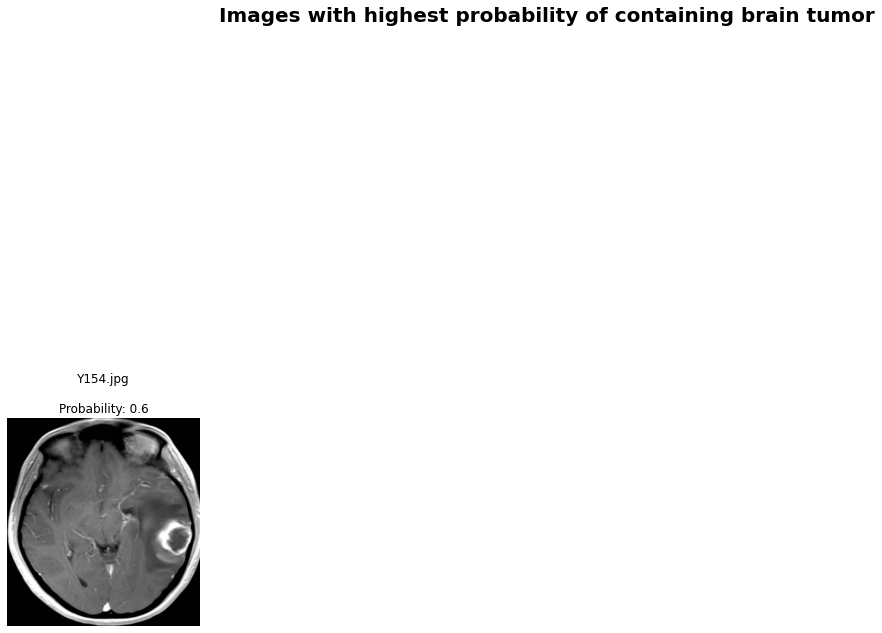

In [25]:
most_confident_tumor_images = get_images_with_sorted_probabilities(prediction_table, True, 1, 10, False)
message = 'Images with highest probability of containing brain tumor'
display(most_confident_tumor_images, message)

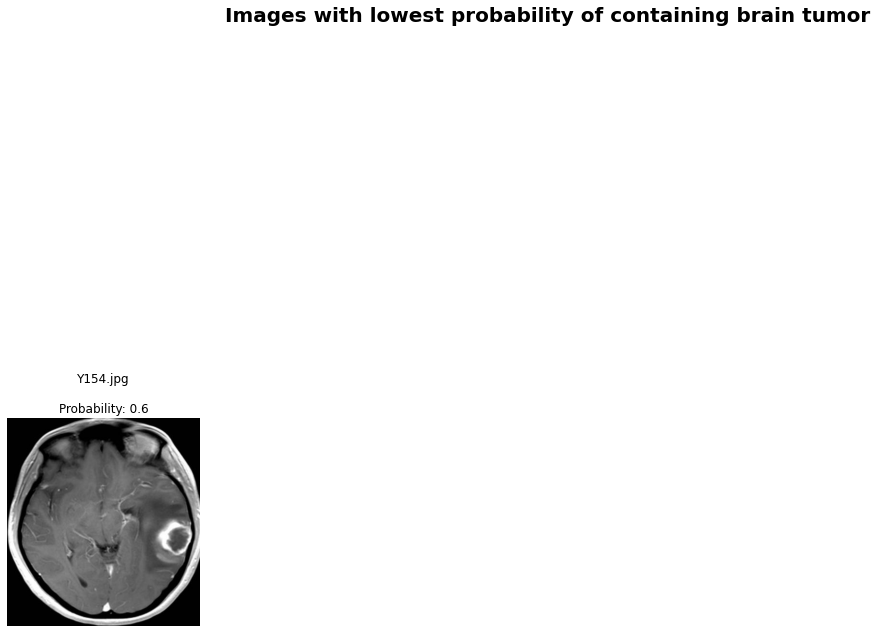

In [26]:
least_confident_tumor_images = get_images_with_sorted_probabilities(prediction_table, False, 1, 10, False)
message = 'Images with lowest probability of containing brain tumor'
display(least_confident_tumor_images, message)

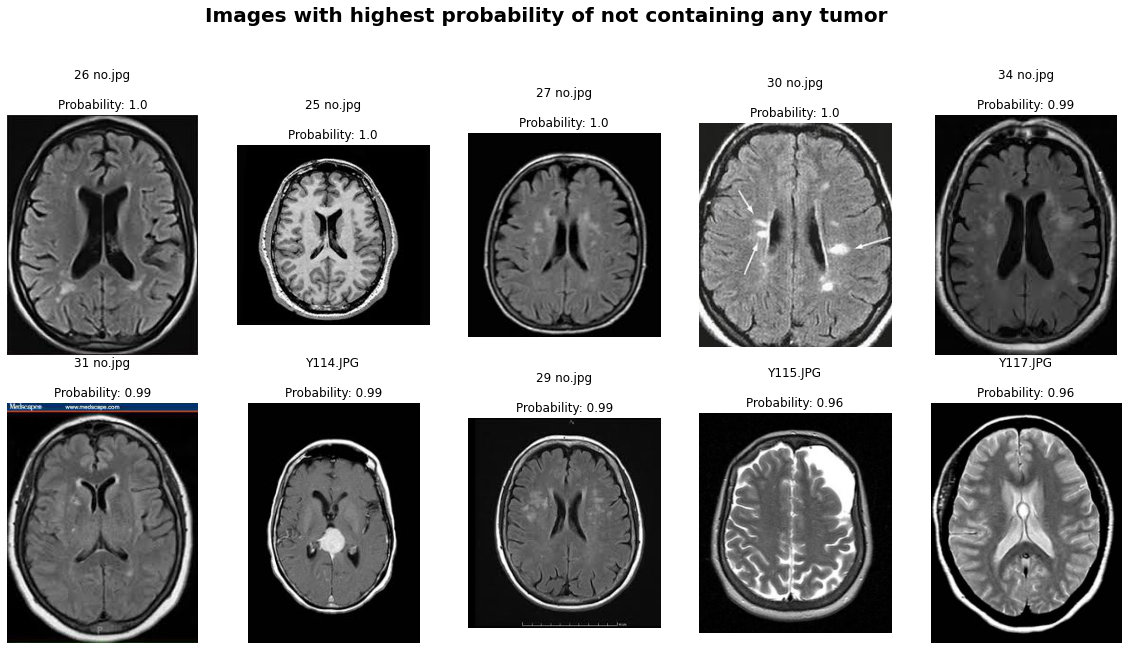

In [27]:
most_confident_no_tumor_images = get_images_with_sorted_probabilities(prediction_table, True, 0, 10, False)
message = 'Images with highest probability of not containing any tumor'
display(most_confident_no_tumor_images, message)

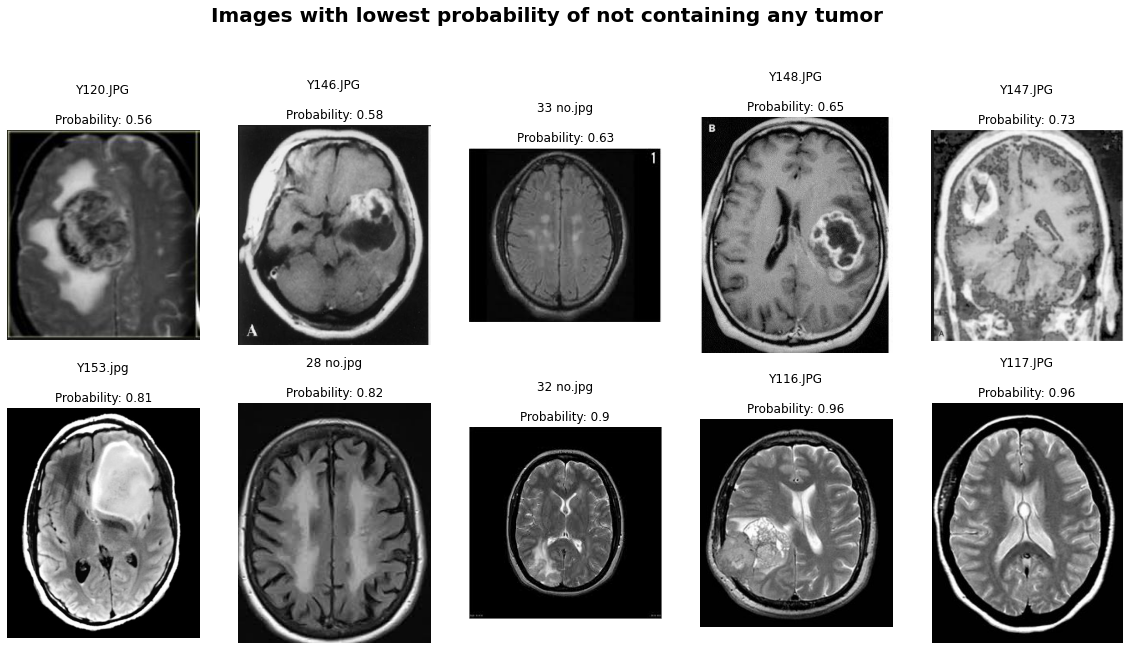

In [28]:
least_confident_no_tumor_images = get_images_with_sorted_probabilities(prediction_table, False, 0, 10,
                                               False)
message = 'Images with lowest probability of not containing any tumor'
display(least_confident_no_tumor_images, message)